In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jan  9 16:27:31 2020

@author: christophe
"""

from math import pi, sin, cos
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse as spa
import scipy.linalg as la
#from matplotlib import rc, rcParams
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)
#rcParams.update({'font.size': 16})

# Some paramters
_eps =1e-12
_maxiter=500

In [2]:
def _basic_check(A, b, x0):
    """ Common check for clarity """
    n, m = A.shape
    if(n != m):
        raise ValueError("Only square matrix allowed")
    if(b.size != n):
        raise ValueError("Bad rhs size")
    if (x0 is None):
        x0 = np.zeros(n)
    if(x0.size != n):
        raise ValueError("Bad initial value size")
    return x0

# I. Model problem

## Question 2.1.1:

We want to solve: 
$$
\left\{
\begin{aligned}
    -u''(x) = f(x), \quad x \in (0,1) \\
    u(0) = u(1) = 0
\end{aligned}
\right.
\quad (1)

$$

We divide the interval $[0,1]$ into $n$ equal segments, with a step size $h = \frac{1}{n}$.
The discrete grid points are 
$x_i = i h, \quad \text{for } i = 0, 1, ..., n.$
and the unknowns are the interior points $x_1, x_2, ..., x_{n-1}$.


We write
$$
u''(x_i) \approx \frac{u_{i-1} - 2u_i + u_{i+1}}{h^2}.
$$
Thus, the equation $-u''(x) = f(x)$ becomes:
$$
-\frac{u_{i-1} - 2u_i + u_{i+1}}{h^2} = f_i,
$$
where $f_i = f(x_i)$.

So 
$$
u_{i-1} - 2u_i + u_{i+1} = -h^2 f_i, \quad i = 1, 2, ..., n-1.
$$
This forms a linear system:
$$
A \mathbf{u} = \mathbf{b},
$$
where:
- $\mathbf{u} = [u_1, u_2, ..., u_{n-1}]^T$ is the vector of unknowns.
- $\mathbf{b} = [-h^2 f_1, -h^2 f_2, ..., -h^2 f_{n-1}]^T$ is the right-hand side.
- $A$ is the laplacian matrix of size $(n-1) \times (n-1)$:

$$
A =
\begin{bmatrix}
-2 & 1  & 0  & 0  & \cdots & 0 \\
1  & -2 & 1  & 0  & \cdots & 0 \\
0  & 1  & -2 & 1  & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0  & 0  & 0  & 1  & -2 & 1 \\
0  & 0  & 0  & 0  & 1  & -2
\end{bmatrix}.
$$

## Question 2.1.2:

In [288]:
def laplace(n):
    """ Construct the 1D laplace operator """
    A = np.zeros((n,n))
    A[0,0] = -2
    A[0,1] = 1
    A[n-1,n-1] = -2
    A[n-1,n-2] = 1
    for i in range(1,n-1):
        A[i,i] = -2
        A[i,i-1] = 1
        A[i,i+1] = 1
    return A

In [289]:
laplace(5)

array([[-2.,  1.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  1., -2.]])

# II. Smoother

## Question 2.2.1:

In [290]:
def JOR(A, b, x0=None, omega=0.5, eps=_eps, maxiter=_maxiter):
    """
    Solve A x = b
    - A is the sparse matrix
    - b is the right hand side (np.array)
    - omega is the relaxation parameter
    - eps is the convergence threshold
    - maxiter limits the number of iterations

    Methode itérative stationnaire de sur-relaxation (Jacobi over relaxation)
    Convergence garantie si A est à diagonale dominante stricte
    A = D - E - F avec D diagonale, E (F) tri inf. (sup.) stricte
    Le préconditionneur est diagonal M = (1./omega) * D


    Output:
        - x is the solution at convergence or after maxiter iteration
        - residual_history is the norm of all residuals
    """
    x = _basic_check(A, b, x0)
    r = np.zeros(x.shape)
    residual_history = list()

    # use spa
    # D = spa.diags(A.diagonal())
    D = np.diag(np.diag(A))
    M = (D/omega)
    N = M - A
    assert np.allclose(A, M - N), "Some error was made in the splitting"

    # inv M with spa (easy since M is diagonal)
    # M_inv = spa.diags(1./M.diagonal())
    # print(M_inv)

    M_inv = np.linalg.inv(M)
    c = M_inv @ b
    M_inv_N = M_inv @ N

    for i in range(maxiter):
        x = M_inv_N @ x + c
        r = b - A @ x
        residual_history.append(np.linalg.norm(r))
        if np.linalg.norm(r) < eps:
            break
    
    return x, residual_history


Found solution x = [ -6.42857143 -12.85714286 -14.28571429 -15.71428571 -11.14285714
  -8.57142857]
Residual = 5.4178663915426235e-11


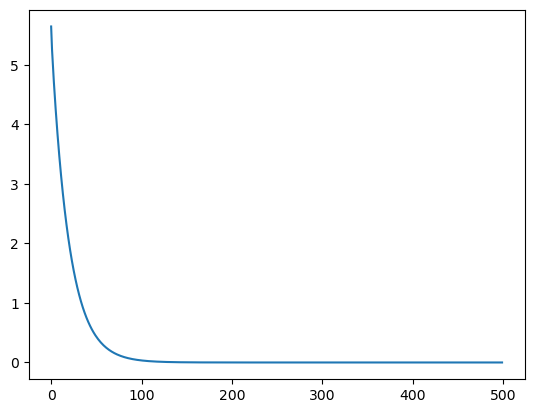

In [316]:
A = laplace(6)
b = np.array([0, 5, 0, 6, -2, 6])

x, residual_history = JOR(A, b)

print(f"Found solution x = {x}")
print(f"Residual = {residual_history[-1]}")

plt.plot(residual_history)

## Question 2.2.2:

In [292]:
def SOR(A, b, x0=None, omega=1.5, eps=_eps, maxiter=_maxiter):
    """
    Solve A x = b where
    - A is the sparse matrix
    - b is the right hand side (np.array)
    - omega is the relaxation parameter
    - eps is the convergence threshold
    - maxiter limits the number of iterations

    Methode itérative stationnaire de sur-relaxation successive
    (Successive Over Relaxation)

    A = D - E - F avec D diagonale, E (F) tri inf. (sup.) stricte
    Le préconditionneur est tri. inf. M = (1./omega) * D - E

    * Divergence garantie pour omega <= 0. ou omega >= 2.0
    * Convergence garantie si A est symétrique définie positive pour
    0 < omega  < 2.
    * Convergence garantie si A est à diagonale dominante stricte pour
    0 < omega  <= 1.

    Output:
        - x is the solution at convergence or after maxiter iteration
        - residual_history is the norm of all residuals

    """
    if (omega > 2.) or (omega < 0.):
        raise ArithmeticError("SOR will diverge")

    x = _basic_check(A, b, x0)
    r = np.zeros(x.shape)
    residual_history = list()

    D = np.diag(np.diag(A))
    E = - np.tril(A, -1)
    F = - np.triu(A, 1)
    assert np.allclose(A, D - E - F), "Some error was made in the splitting 1"

    M = (1/omega) * D - E
    N = M - A
    assert np.allclose(A, M - N), "Some error was made in the splitting 2"

    M_inv = np.linalg.inv(M)
    c = M_inv @ b
    M_inv_N = M_inv @ N

    for i in range(maxiter):
        x = M_inv_N @ x + c
        r = b - A @ x
        residual_history.append(np.linalg.norm(r))
        if np.linalg.norm(r) < eps:
            break
        
    return x, residual_history


Found solution x = [ -6.42857143 -12.85714286 -14.28571429 -15.71428571 -11.14285714
  -8.57142857]
Residual = 2.686530512398488e-13


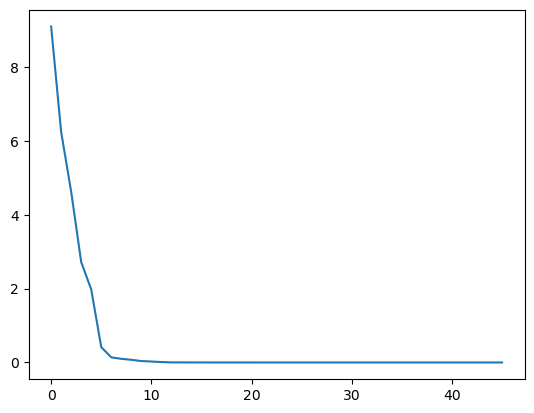

In [308]:
A = laplace(6)
b = np.array([0, 5, 0, 6, -2, 6])
x, residual_history = SOR(A, b)

print(f"Found solution x = {x}")
print(f"Residual = {residual_history[-1]}")

plt.plot(residual_history)

## Question 2.2.3:

The use of a null right-hand-side and a custom initial guess gives some insights about the convergence of the method. Can you explain why ?

In [354]:
def test_engine(b, x0):
    A = laplace(b.size)
    x, residual_history_jor = JOR(A, b, x0)
    x, residual_history_sor = SOR(A, b, x0)
    # print(f"Found solution x = {x}")
    print(f"Residual = {residual_history_jor}")
    print(f"Residual = {residual_history_sor}")
    plt.plot(residual_history_jor, label="JOR")
    plt.plot(residual_history_sor, label="SOR")
    # round x0 to 2 decimals
    x0 = np.round(x0, 2)
    plt.title(f"Residual history for x0 = {x0}")
    plt.legend()

Residual = [0.4126607264977445, 0.27683846437508125, 0.20866527012350164, 0.17225587987825283, 0.15183748708886624, 0.13899416238720805, 0.129681699508858, 0.12209566103485162, 0.11545170992778113, 0.1094034428014131, 0.10378925521098467, 0.09852644145235842, 0.0935672321125676, 0.08888030671325332, 0.08444276999334054, 0.08023648627562009, 0.07624628294181893, 0.07245899398632229, 0.0688629064245998, 0.06544741551500306, 0.062202797241037645, 0.059120051477991, 0.05619079018236754, 0.05340715540581166, 0.05076175760439837, 0.04824762802329072, 0.04585818098792269, 0.04358718326020578, 0.04142872850185037, 0.03937721548553409, 0.03742732910458031, 0.03557402351434077, 0.033812506934000286, 0.03213822777322016, 0.030546861842437913, 0.02903430047146577, 0.027596639407052082, 0.02623016839235374, 0.02493136135401301, 0.023696867138647187, 0.022523500752062397, 0.02140823506279095, 0.02034819293759698, 0.019340639781069025, 0.018382976454790537, 0.017472732554173215, 0.01660756002308025, 

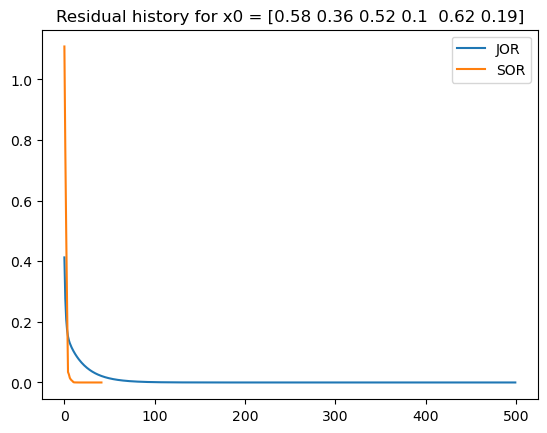

In [355]:
b = np.zeros(6) # null right hand side
x0 = np.random.rand(6) # random initial guess

test_engine(b, x0)

## Question 2.2.4:

Residual = [0.4388558832874337, 0.34293545995032265, 0.2863466152784208, 0.24796486369257098, 0.2196706744630694, 0.19747059829541794, 0.17916880422409218, 0.16350399842689312, 0.1497358312183371, 0.1374191574957329, 0.12627635528834005, 0.11612514256128217, 0.10683808201330965, 0.09831998733287833, 0.09049532670449767, 0.08330116450266921, 0.07668315771366607, 0.07059323566391873, 0.06498820957516323, 0.05982889904596331, 0.0550795493412869, 0.05070741551663379, 0.04668244518281296, 0.04297702216592703, 0.03956574994723848, 0.03642526286547643, 0.033534058057193415, 0.030872343866241183, 0.028421901988155467, 0.026165961482908433, 0.024089083291627938, 0.022177054193764815, 0.02041678933037834, 0.018796242545609236, 0.017304323888785517, 0.01593082368866974, 0.014666342667244502, 0.013502227607701048, 0.012430512132534717, 0.011443862184378286, 0.010535525835342395, 0.009699287080773607, 0.008929423300890037, 0.008220666099008818, 0.007568165248270332, 0.0069674555000820764, 0.0064144

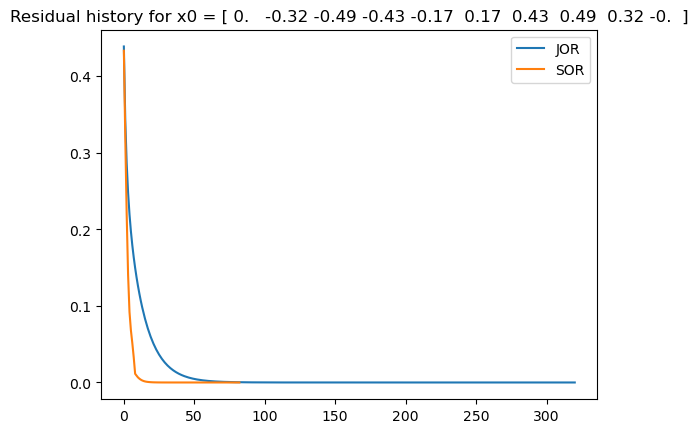

In [365]:
b = np.zeros(10) # null right hand side
grid = np.linspace(0, 1, 10)
x0 = 0.5 * np.sin(16. * grid * pi) # low frequency initial guess

test_engine(b, x0)

Residual = [0.9257374818683833, 0.5411204355836445, 0.3507224403923767, 0.24034589357430955, 0.16921794310052732, 0.12096703634550221, 0.08761159003203606, 0.06447295754377001, 0.04847701534010593, 0.03748152057029799, 0.029947640316995948, 0.024758651912015515, 0.021115110155752504, 0.018465391837482328, 0.016447038274833188, 0.014832697826717076, 0.013484516512935312, 0.012320308472204174, 0.01129101098932902, 0.01036674505839548, 0.009528603511695079, 0.008763953405803115, 0.008063792676976543, 0.007421273779317443, 0.00683087938747515, 0.006287959166871152, 0.005788465663294716, 0.005328799970350676, 0.004905718123035506, 0.004516271344805605, 0.004157765429159004, 0.003827731180074494, 0.0035239014627903294, 0.003244192396489311, 0.002986687302301902, 0.0027496226123157204, 0.002531375270749976, 0.002330451338459327, 0.002145475612549415, 0.0019751821300953375, 0.0018184054583497587, 0.0016740726940865044, 0.001541196107671967, 0.0014188663762719374, 0.0013062463570285975, 0.00120

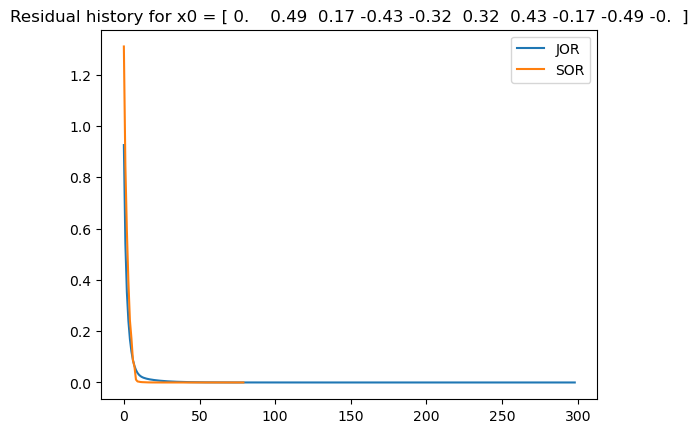

In [366]:
b = np.zeros(10) # null right hand side
grid = np.linspace(0, 1, 10)
x0 = 0.5 * np.sin(40. * grid * pi) # high frequency initial guess

test_engine(b, x0)

Residual = [0.28952399199957396, 0.10567482923140312, 0.05098540482199786, 0.03159750497114074, 0.023450274153251745, 0.018602167587707497, 0.015018355142608523, 0.012175782711027452, 0.009880780778558801, 0.008020142982527706, 0.006510211419007797, 0.005284612539062431, 0.004289753859454259, 0.0034821851845011392, 0.002826645948995049, 0.0022945154137473294, 0.0018625611831023271, 0.0015119245422869766, 0.001227297037648947, 0.0009962521122107264, 0.0008087025721222306, 0.000656460189287765, 0.0005328782113172989, 0.0004325611708531472, 0.0003511293247800729, 0.00028502743895699465, 0.00023136957019829652, 0.00018781306883868635, 0.0001524563009576998, 0.00012375562491696575, 0.00010045799748767422, 8.154626721819468e-05, 6.619476660419311e-05, 5.3733264259163294e-05, 4.361770327266599e-05, 3.5406448221836775e-05, 2.8741003804095644e-05, 2.3330363285566175e-05, 1.8938303433888046e-05, 1.5373071244711743e-05, 1.247901219451863e-05, 1.0129774517535885e-05, 8.22279281217399e-06, 6.674810

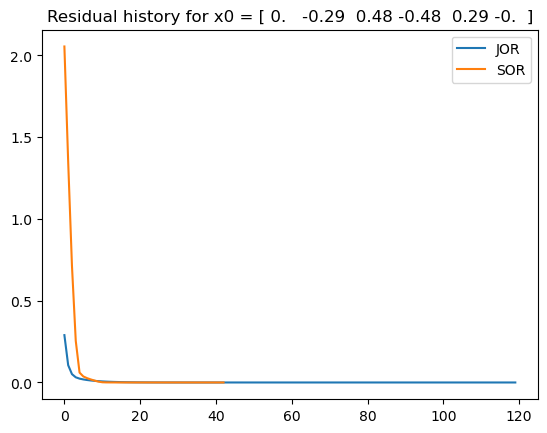

In [363]:
b = np.zeros(6) # null right hand side
grid = np.linspace(0, 1, 6)
x0 = 0.5 * (np.sin(16. * grid * pi) + np.sin(40. * grid * pi))

test_engine(b, x0)

# III. Restriction & prolongation

## Question 2.3.1:

In [294]:
def injection(fine, n_inc_H, coarse=None):
    """
    Classical injection, that only keep the value of the coarse nodes
    The modification of coarse is done inplace
    """
    if coarse is None:
        coarse = np.zeros(n_inc_H)
    else:
        coarse[:] = fine[::2]

    return coarse

## Question 2.3.2:

In [295]:
def interpolation(coarse, n_inc_h, fine=None):
    """
    Classical linear interpolation (the modification of fine is done inplace)
    """

    if fine is None:
        fine = np.zeros(n_inc_h)

    fine[1::2] = coarse
    fine[0] = 0.5 * coarse[0]
    fine[-1] = 0.5 * coarse[-1]
    if n_inc_h >=8:
        fine[2:-2:2] = 0.5 * (coarse[:-1] + coarse[1:])

    return fine

In [296]:
def plot(x, y, custom, label=""):
    """
    A custom plot function, usage:
        f, ax = plot(x, y,'-x', label="u")
    """
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.plot(x, y, custom, label=label);
    ax.set_xlabel(r"x")
    ax.set_ylabel(r"u(x)")
    f.tight_layout()
    return f, ax

# IV. Two-grid algorithm

## Question 2.4.1:

In [297]:
def tgcyc(nsegment=64, engine=JOR, function_f=None, **kwargs):
    """
    Two grid cycle:
        - nsegment: the number of segment so that h = 1.0/nsegment
        - engine: the stationary iterative method used for smoothing

    Warning: make the good distinction between the number of segments, the
    number of nodes and the number of unknowns
    """

    if(nsegment%2): raise ValueError("nsegment must be even")
    if function_f is None: # default function
        def function_f(x):
            return np.sin(2.5 * pi * x)

    # Beware that : nsegment
    # n = number of nodes
    # n_inc = number of unknowns
    n = nsegment + 1
    h = 1.0 / nsegment
    H = 2. * h

    n_inc_h = nsegment - 1
    n_inc_H = n_inc_h // 2

    # Full points
    xh = np.linspace(0.,1., n)
    xH = np.linspace(0.,1., n//2 + 1)
    # Inner points
    xih = xh[1:-1]
    xiH = xH[1:-1]

    # construction of Laplace operator
    Ah = (1/(h*h)) * laplace(n_inc_h)
    AH = (1/(H*H)) * laplace(n_inc_H)

    # Initial guess 
    u0 = 0.5 * (np.sin(16. * xih * pi) + np.sin(40. * xih * pi))
    u = u0.copy()

    # The given right hand side
    bh = function_f(xih)

    # Pre-smoothing Relaxation
    u, _ = engine(Ah, bh, u, **kwargs)
    rh = bh - Ah @ u

    # Restriction with injection
    rH = injection(rh, n_inc_H)

    # Solve on the coarse grid
    vH = np.linalg.solve(AH, rH)

    # Prolongation
    vh = interpolation(vH, n_inc_h)

    # Update solution
    u += vh

    # Post-smoothing Relaxation
    u, _ = engine(Ah, bh, u, **kwargs)

    return u

In [298]:
u = tgcyc(nsegment=32, engine=JOR)
u

array([-0.00355819, -0.00687806, -0.0097355 , -0.01193405, -0.01331656,
       -0.01377459, -0.01325486, -0.0117624 , -0.0093602 , -0.00616541,
       -0.00234224,  0.00190784,  0.00635828,  0.010771  ,  0.0149107 ,
        0.01855895,  0.02152735,  0.02366875,  0.02488613,  0.02513835,
        0.02444266,  0.02287362,  0.02055859,  0.01767011,  0.0144155 ,
        0.0110244 ,  0.00773499,  0.00477963,  0.00237094,  0.00068894,
       -0.0001297 ])

In [299]:
list_n_segment = [8, 16, 32, 64, 128]

# def function_f(x):
#     return np.sin(6 * pi * x)

def function_f(x):
    return np.sqrt(1 - 4 * (x - 0.5)**2)

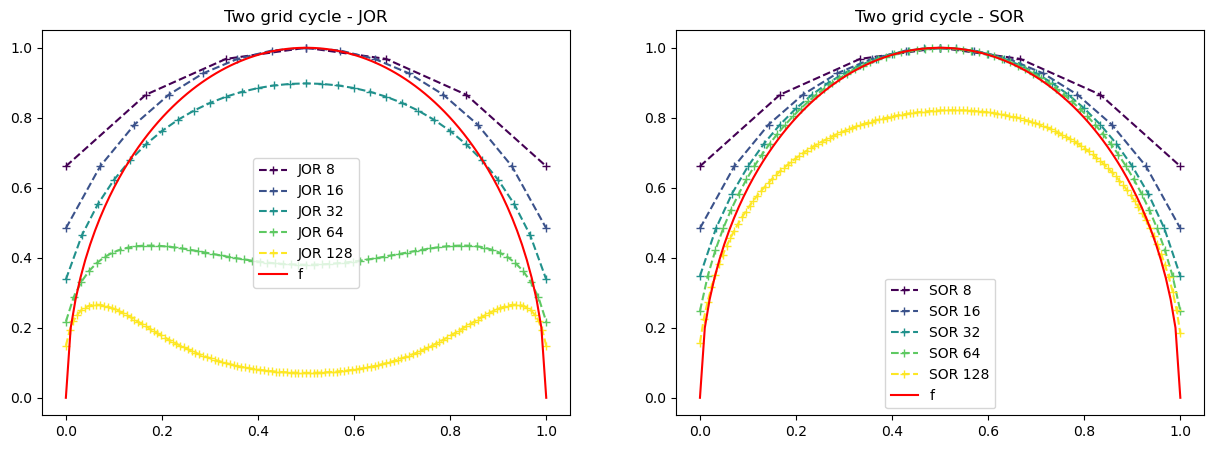

In [300]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

nb_colors = len(list_n_segment)
colors = plt.cm.viridis(np.linspace(0, 1, nb_colors))

for i, nsegment in enumerate(list_n_segment):
    h = 1.0 / nsegment
    Ah = (1/(h*h)) * laplace(nsegment-1)
    u_jor = tgcyc(nsegment=nsegment, engine=JOR, function_f=function_f)
    u_sor = tgcyc(nsegment=nsegment, engine=SOR, function_f=function_f)
    x = np.linspace(0.,1., nsegment-1)
    axs[0].plot(x, Ah @ u_jor, label=f"JOR {nsegment}", linestyle="--", c=colors[i], marker="+")
    axs[1].plot(x, Ah @ u_sor, label=f"SOR {nsegment}", linestyle="--", c=colors[i], marker="+")
x = np.linspace(0.,1., 100)
axs[0].plot(x, function_f(x), label="f", linestyle="-", c="r")
axs[1].plot(x, function_f(x), label="f", linestyle="-", c="r")
axs[0].set_title("Two grid cycle - JOR")
axs[1].set_title("Two grid cycle - SOR")
axs[0].legend()
axs[1].legend()
plt.show()

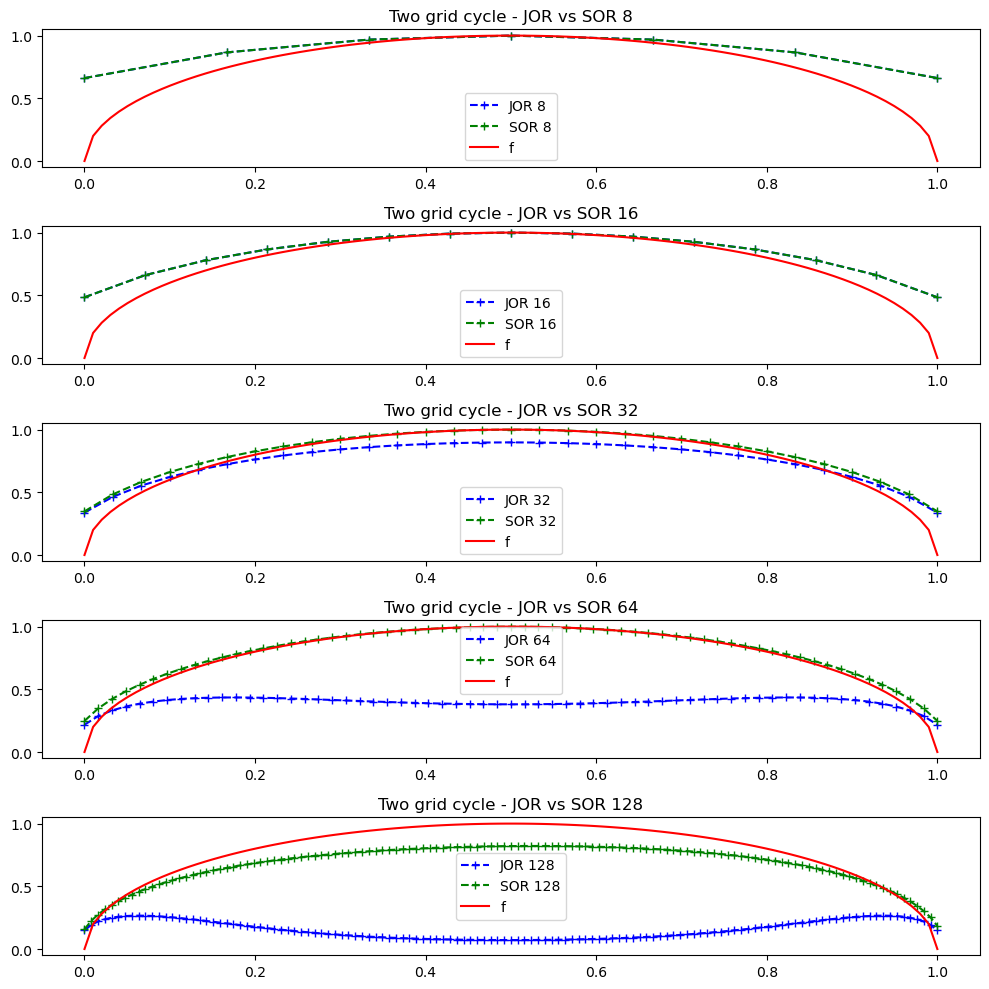

In [301]:
# JOR vs SOR
fig, axs = plt.subplots(len(list_n_segment), 1, figsize=(10, 10))

for i, nsegment in enumerate(list_n_segment):
    h = 1.0 / nsegment
    Ah = (1/(h*h)) * laplace(nsegment-1)
    u_jor = tgcyc(nsegment=nsegment, engine=JOR, function_f=function_f)
    u_sor = tgcyc(nsegment=nsegment, engine=SOR, function_f=function_f)
    x = np.linspace(0.,1., nsegment-1)
    axs[i].plot(x, Ah @ u_jor, label=f"JOR {nsegment}", linestyle="--", c="b", marker="+")
    axs[i].plot(x, Ah @ u_sor, label=f"SOR {nsegment}", linestyle="--", c="g", marker="+")
    x = np.linspace(0.,1., 100)
    axs[i].plot(x, function_f(x), label="f", linestyle="-", c="r")
    axs[i].set_title(f"Two grid cycle - JOR vs SOR {nsegment}")
    axs[i].legend()
plt.tight_layout()
plt.show()

## Question 2.4.2:

In [302]:
def three_gcyc(nsegment=64, engine=JOR, function_f=None, **kwargs):
    """
    Three grid cycle:
        - nsegment: the number of segment so that h = 1.0/nsegment
        - engine: the stationary iterative method used for smoothing

    Warning: make the good distinction between the number of segments, the
    number of nodes and the number of unknowns
    """

    if(nsegment%4): raise ValueError("nsegment must be a multiple of 4")

    if function_f is None: # default function
        def function_f(x):
            return np.sin(2.5 * pi * x)

    # Beware that : nsegment
    # n = number of nodes
    # n_inc = number of unknowns
    n = nsegment + 1
    h = 1.0 / nsegment
    H = 2. * h

    n_inc_h = nsegment - 1
    n_inc_H = n_inc_h // 2

    # Full points
    xh = np.linspace(0.,1., n)
    xH = np.linspace(0.,1., n//2 + 1)
    # Inner points
    xih = xh[1:-1]
    xiH = xH[1:-1]

    # construction of Laplace operator
    Ah = (1/(h*h)) * laplace(n_inc_h)
    AH = (1/(H*H)) * laplace(n_inc_H)

    # Initial guess 
    u0 = 0.5 * (np.sin(16. * xih * pi) + np.sin(40. * xih * pi))
    u = u0.copy()

    # The given right hand side
    bh = function_f(xih)

    # Pre-smoothing Relaxation
    u, _ = engine(Ah, bh, u, **kwargs)
    rh = bh - Ah @ u

    # Restriction with injection
    rH = injection(rh, n_inc_H)

    # Solve on the coarse grid using a two grid cycle
    vH = tgcyc(nsegment=nsegment//2, engine=engine, function_f=function_f, **kwargs)

    # Prolongation
    vh = interpolation(vH, n_inc_h)

    # Update solution
    u += vh

    # Post-smoothing Relaxation
    u, _ = engine(Ah, bh, u, **kwargs)

    return u

In [303]:
list_n_segment = [16, 32, 64, 128]

# def function_f(x):
#     return np.sin(6 * pi * x)

def function_f(x):
    return np.sqrt(1 - 4 * (x - 0.5)**2)

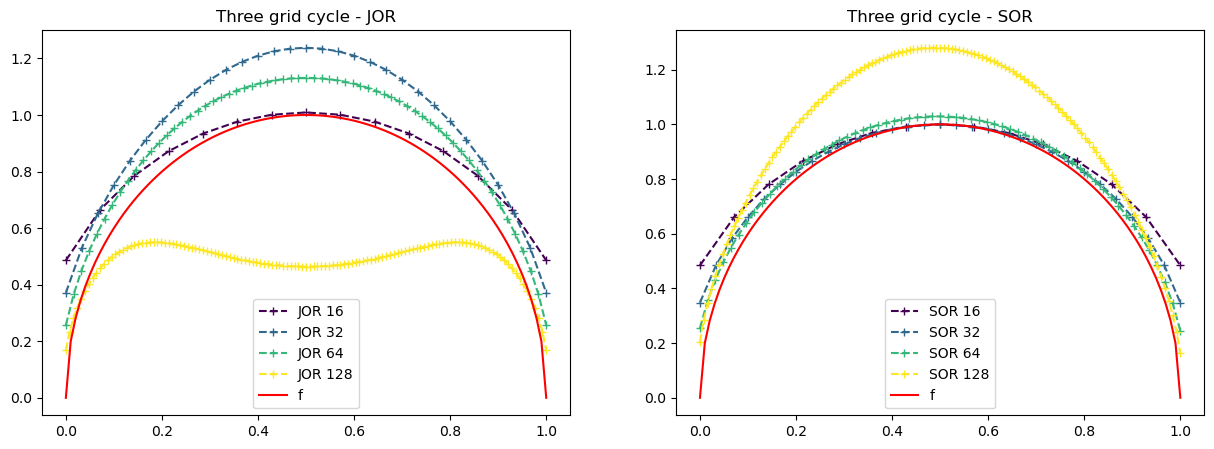

In [367]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

nb_colors = len(list_n_segment)
colors = plt.cm.viridis(np.linspace(0, 1, nb_colors))

for i, nsegment in enumerate(list_n_segment):
    h = 1.0 / nsegment
    Ah = (1/(h*h)) * laplace(nsegment-1)
    u_jor = three_gcyc(nsegment=nsegment, engine=JOR, function_f=function_f)
    u_sor = three_gcyc(nsegment=nsegment, engine=SOR, function_f=function_f)
    x = np.linspace(0.,1., nsegment-1)
    axs[0].plot(x, Ah @ u_jor, label=f"JOR {nsegment}", linestyle="--", c=colors[i], marker="+")
    axs[1].plot(x, Ah @ u_sor, label=f"SOR {nsegment}", linestyle="--", c=colors[i], marker="+")
x = np.linspace(0.,1., 100)
axs[0].plot(x, function_f(x), label="f", linestyle="-", c="r")
axs[1].plot(x, function_f(x), label="f", linestyle="-", c="r")
axs[0].set_title("Three grid cycle - JOR")
axs[1].set_title("Three grid cycle - SOR")
axs[0].legend()
axs[1].legend()
plt.show()

## Question 2.4.3:

In [305]:
def multi_gcyc(nb_grid=2, nsegment=64, engine=JOR, function_f=None, **kwargs):
    """
    Multi grid cycle:
        - nb_grid: the number of grid cycle
        - nsegment: the number of segment so that h = 1.0/nsegment
        - engine: the stationary iterative method used for smoothing

    Warning: make the good distinction between the number of segments, the
    number of nodes and the number of unknowns
    """

    if(nsegment%(2**(nb_grid-1))): raise ValueError("nsegment must be a multiple of 2^(nb_grid-1)")
    if nsegment <= 2**nb_grid: raise ValueError("nsegment must be greater than 2^nb_grid")

    if function_f is None: # default function
        def function_f(x):
            return np.sin(2.5 * pi * x)

    # Beware that : nsegment
    # n = number of nodes
    # n_inc = number of unknowns
    n = nsegment + 1
    h = 1.0 / nsegment
    H = 2. * h

    n_inc_h = nsegment - 1
    n_inc_H = n_inc_h // 2

    # Full points
    xh = np.linspace(0.,1., n)
    xH = np.linspace(0.,1., n//2 + 1)
    # Inner points
    xih = xh[1:-1]
    xiH = xH[1:-1]

    # construction of Laplace operator
    Ah = (1/(h*h)) * laplace(n_inc_h)
    AH = (1/(H*H)) * laplace(n_inc_H)

    # Initial guess 
    u0 = 0.5 * (np.sin(16. * xih * pi) + np.sin(40. * xih * pi))
    u = u0.copy()

    # The given right hand side
    bh = function_f(xih)

    # Pre-smoothing Relaxation
    u, _ = engine(Ah, bh, u, **kwargs)
    rh = bh - Ah @ u

    # Restriction with injection
    rH = injection(rh, n_inc_H)

    # Solve on the coarse grid using a multi grid cycle (recursive)
    if nb_grid == 2:
        vH = np.linalg.solve(AH, rH)
    else:
        vH = multi_gcyc(nb_grid-1, nsegment//2, engine=engine, function_f=function_f, **kwargs)

    # Prolongation
    vh = interpolation(vH, n_inc_h)

    # Update solution
    u += vh

    # Post-smoothing Relaxation
    u, _ = engine(Ah, bh, u, **kwargs)

    return u


def plot_multi_gcyc(list_nb_grid, function_f):
    fig, axs = plt.subplots(len(list_nb_grid), 2, figsize=(10, 10))
    for i, nb_grid in enumerate(list_nb_grid):
        list_n_segment = [2**j for j in range(nb_grid+1, 8)]
        nb_colors = len(list_n_segment)
        colors = plt.cm.viridis(np.linspace(0, 1, nb_colors))
        for j, nsegment in enumerate(list_n_segment):
            h = 1.0 / nsegment
            Ah = (1/(h*h)) * laplace(nsegment-1)
            u_jor = multi_gcyc(nb_grid=nb_grid, nsegment=nsegment, engine=JOR, function_f=function_f)
            u_sor = multi_gcyc(nb_grid=nb_grid, nsegment=nsegment, engine=SOR, function_f=function_f)
            x = np.linspace(0.,1., nsegment-1)
            axs[i, 0].plot(x, Ah @ u_jor, label=f"JOR {nsegment}", linestyle="--", c=colors[j], marker="+")
            axs[i, 1].plot(x, Ah @ u_sor, label=f"SOR {nsegment}", linestyle="--", c=colors[j], marker="+")
        x = np.linspace(0.,1., 100)
        axs[i, 0].plot(x, function_f(x), label="f", linestyle="-", c="r")
        axs[i, 1].plot(x, function_f(x), label="f", linestyle="-", c="r")
        axs[i, 0].set_title(f"{list_nb_grid[i]} grid cycle - JOR")
        axs[i, 1].set_title(f"{list_nb_grid[i]} grid cycle - SOR")
        axs[i, 0].legend()
        axs[i, 1].legend()
    plt.tight_layout()
    plt.show()

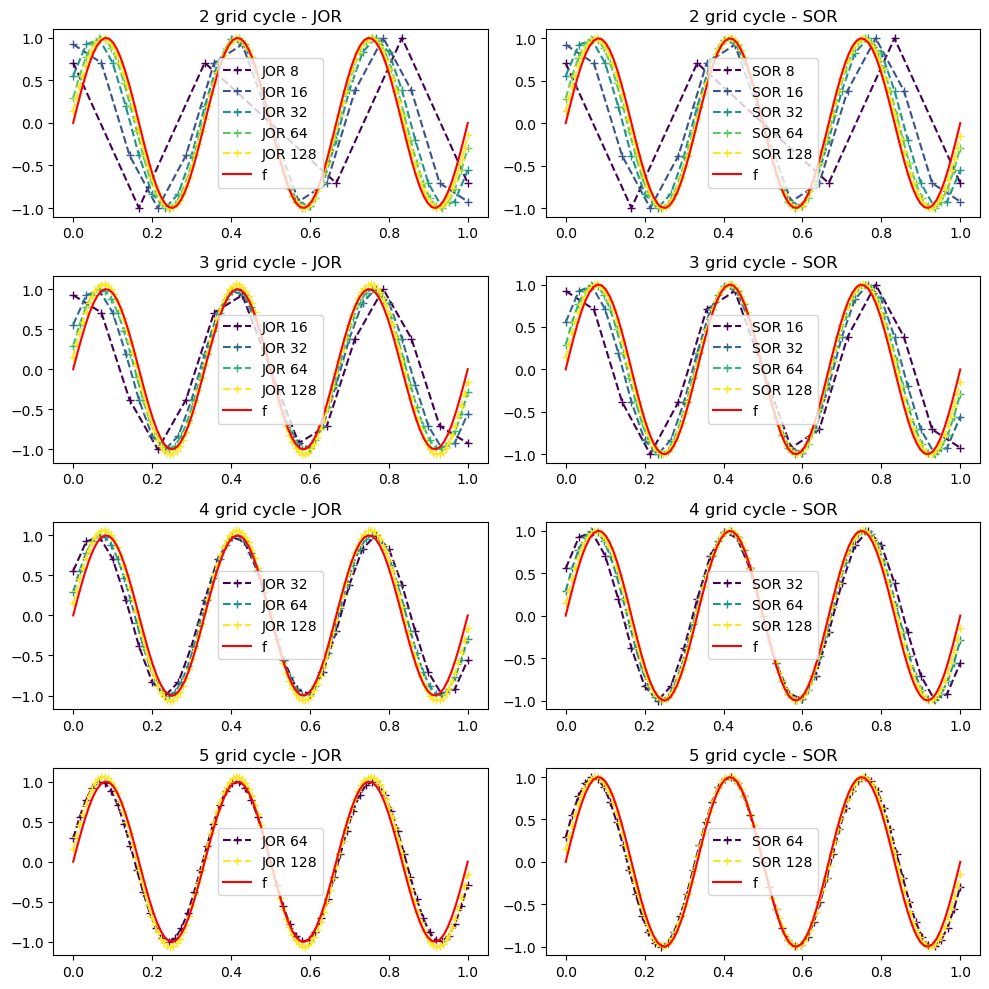

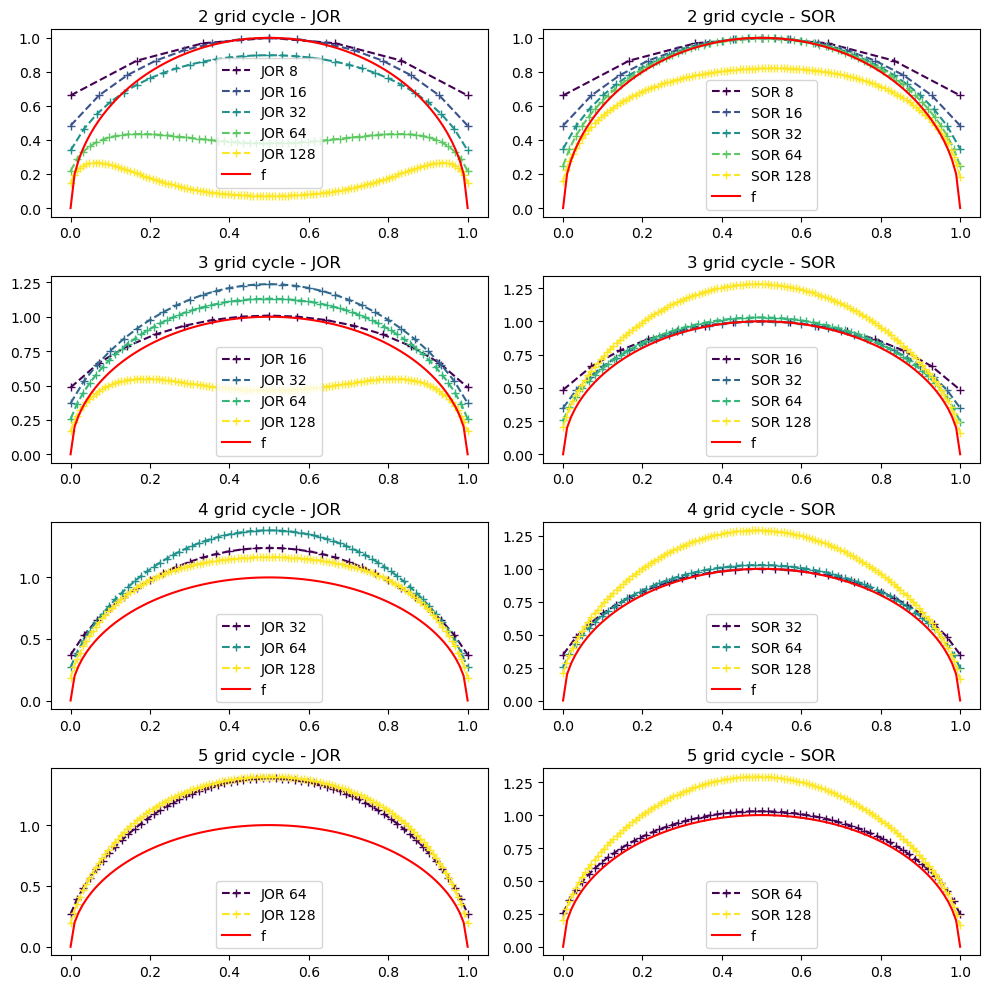

In [306]:
list_nb_grid = [2, 3, 4, 5]

def function_f(x):
    return np.sin(6 * pi * x)
plot_multi_gcyc(list_nb_grid, function_f)

def function_f(x):
    return np.sqrt(1 - 4 * (x - 0.5)**2)
plot_multi_gcyc(list_nb_grid, function_f)